# ポワソン回帰
+ 冠動脈心疾患と喫煙習慣

In [1]:
import numpyro
import numpyro.distributions as dist

import jax
import arviz as az

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

In [2]:
# cpu がどんな感じで動いているか？
jax.devices()

[CpuDevice(id=0)]

In [3]:
df = pd.DataFrame({
    'agecat': [1, 2, 3, 4, 5, 1, 2, 3, 4, 5],
    'deaths': [32, 104, 206, 186, 102, 2,12, 28, 28, 31],
    'population': [52407, 43248, 28612, 12663, 5317, 18790, 10673, 5710, 2585, 1462],
    'smoke': [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
})

データ：「年齢層別に喫煙者と非喫煙者で死亡率がどの程度変化するか（人年が分母）」

Text(0, 0.5, 'Death Rate')

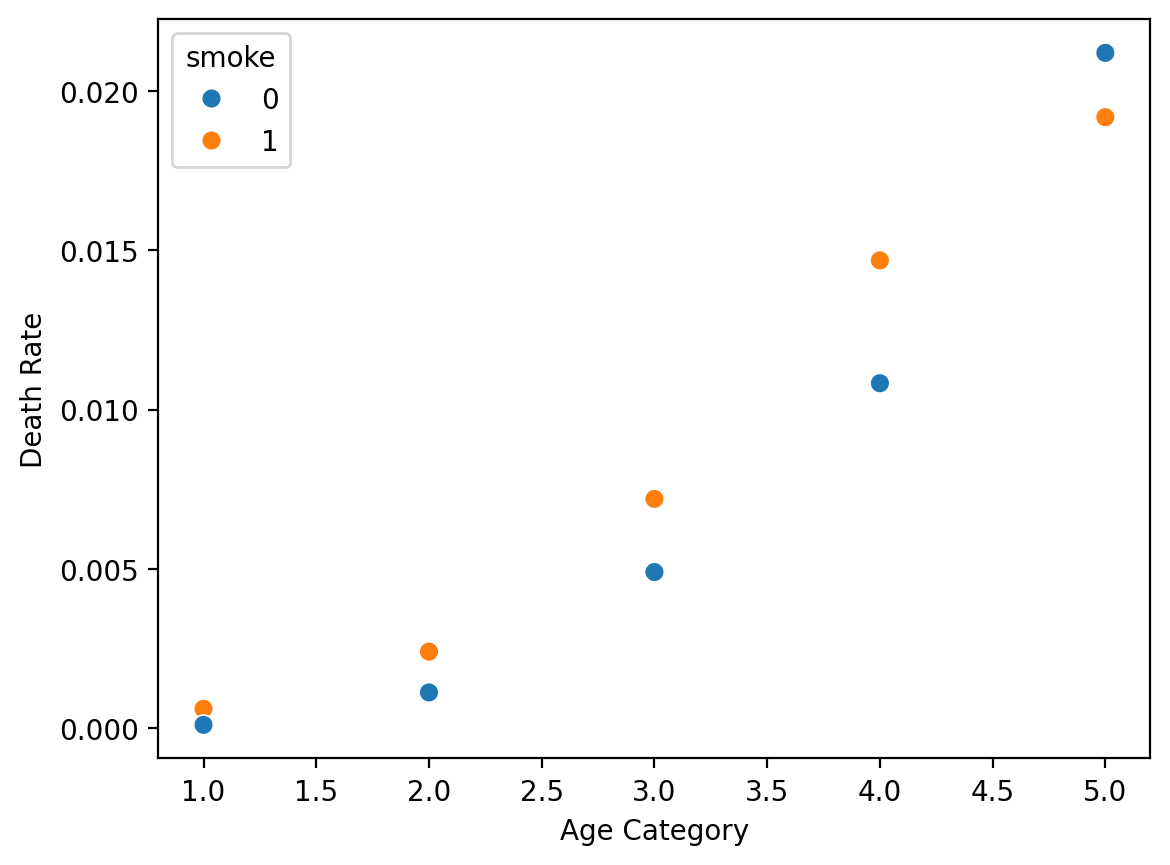

In [4]:
sns.scatterplot(x = df['agecat'], y = df['deaths'] / df['population'], hue = df['smoke'], s = 50)

plt.xlabel("Age Category")
plt.ylabel("Death Rate")

死亡率を対数ケールにするとどうなるか？<br>
本来だったらシンプルなポワソン回帰で説明できるならば以下の図が直線的になるはずだが、そうなってない（曲線っぽい）ので、なんかありそう<br>
あとでモデルの中に `age_scaled` の2乗項 も入れたりする

Text(0, 0.5, 'Death Rate')

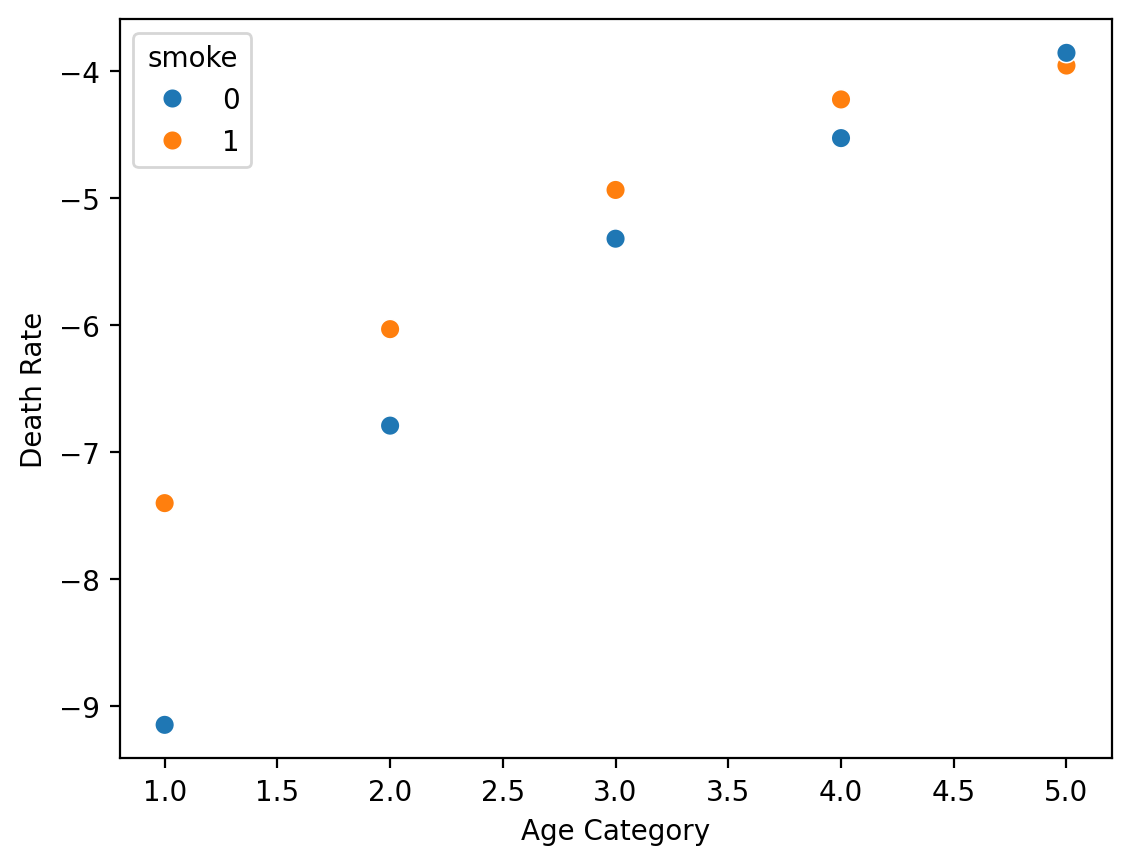

In [5]:
sns.scatterplot(x = df['agecat'], y = np.log(df['deaths'] / df['population']), hue = df['smoke'], s = 50)

plt.xlabel("Age Category")
plt.ylabel("Death Rate")

In [6]:
agecat = df['agecat'].values
deaths = df['deaths'].values
smoke = df['smoke'].values

population = df['population'].values

回帰の場合は標準化<br>
（年齢区分は離散のカテゴリーデータだが、順序があるので一応連続値の特徴量としてみているため標準化している）

In [7]:
agecat_mu = np.mean(agecat)
agecat_sd = np.std(agecat)

agecat_scaled = (agecat - agecat_mu) / agecat_sd

グラフでは `death rate` として示したが、モデルの中では割り算をせずに offset項 を利用する 

モデル比較のため、ロジスティックの場合のスクリプトを以下に残しておく

やってることは基本的に変わらない

+ 線形予測子のパラメーター決めて
+ 分布の引数の元を作成し
+ 分布の引数の元をリンク関数でそれらしい形に変換し
+ 必要なoffset項追加して
+ 分布のパラメータとする
+ plateでデータの数だけnumpyro.sample()させる

In [8]:
def model(smoke = None, agecat_scaled = None, deaths = None, population = None, num_data = 0):

    b1 = numpyro.sample('b1', dist.Normal(0, 10))
    b2 = numpyro.sample('b2', dist.Normal(0, 10))
    b3 = numpyro.sample('b3', dist.Normal(0, 10))

    theta =  b1 + b2 * smoke + b3 * agecat_scaled # 線形予測子 

    mu = jax.numpy.exp(theta) * population # 線形予測子だけだと負の値も取るので正に固定のため exp をとる。
    # そして母数がどの程度あるか Offset で表現：ex. 人年が10倍とかになれば、muもちょうど10倍になるようにするだけ!!

    # mu = jax.numpy.exp(b1) * jax.numpy.exp(b2 * smoke) * jax.numpy.exp(b3 * agecat_scaled) * population
    # こんな感じで 指数関数なので、積の形に変換してそれぞれ独立して指標を評価できる

    with numpyro.plate('data', num_data):
        numpyro.sample('obs', dist.Poisson(rate = mu), obs = deaths)

In [9]:
nuts = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(nuts, num_warmup = 500, num_samples = 3000, num_chains = 4)

mcmc.run(jax.random.PRNGKey(42)
         , smoke = smoke
         , agecat_scaled = agecat_scaled
         , deaths = deaths
         , population = population
         , num_data = len(agecat_scaled))

mcmc_samples = mcmc.get_samples()

idata = az.from_numpyro(mcmc)

/var/folders/03/smvv0jp54c5cnt0xtqz_1gkc0000gn/T/ipykernel_12467/1652558687.py:2: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(nuts, num_warmup = 500, num_samples = 3000, num_chains = 4)
sample: 100%|█| 3500/3500 [00:01<00:00
sample: 100%|█| 3500/3500 [00:00<00:00
sample: 100%|█| 3500/3500 [00:00<00:00
sample: 100%|█| 3500/3500 [00:00<00:00


In [10]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

array([[<Axes: title={'center': 'b1'}>, <Axes: title={'center': 'b1'}>],
       [<Axes: title={'center': 'b2'}>, <Axes: title={'center': 'b2'}>],
       [<Axes: title={'center': 'b3'}>, <Axes: title={'center': 'b3'}>]],
      dtype=object)

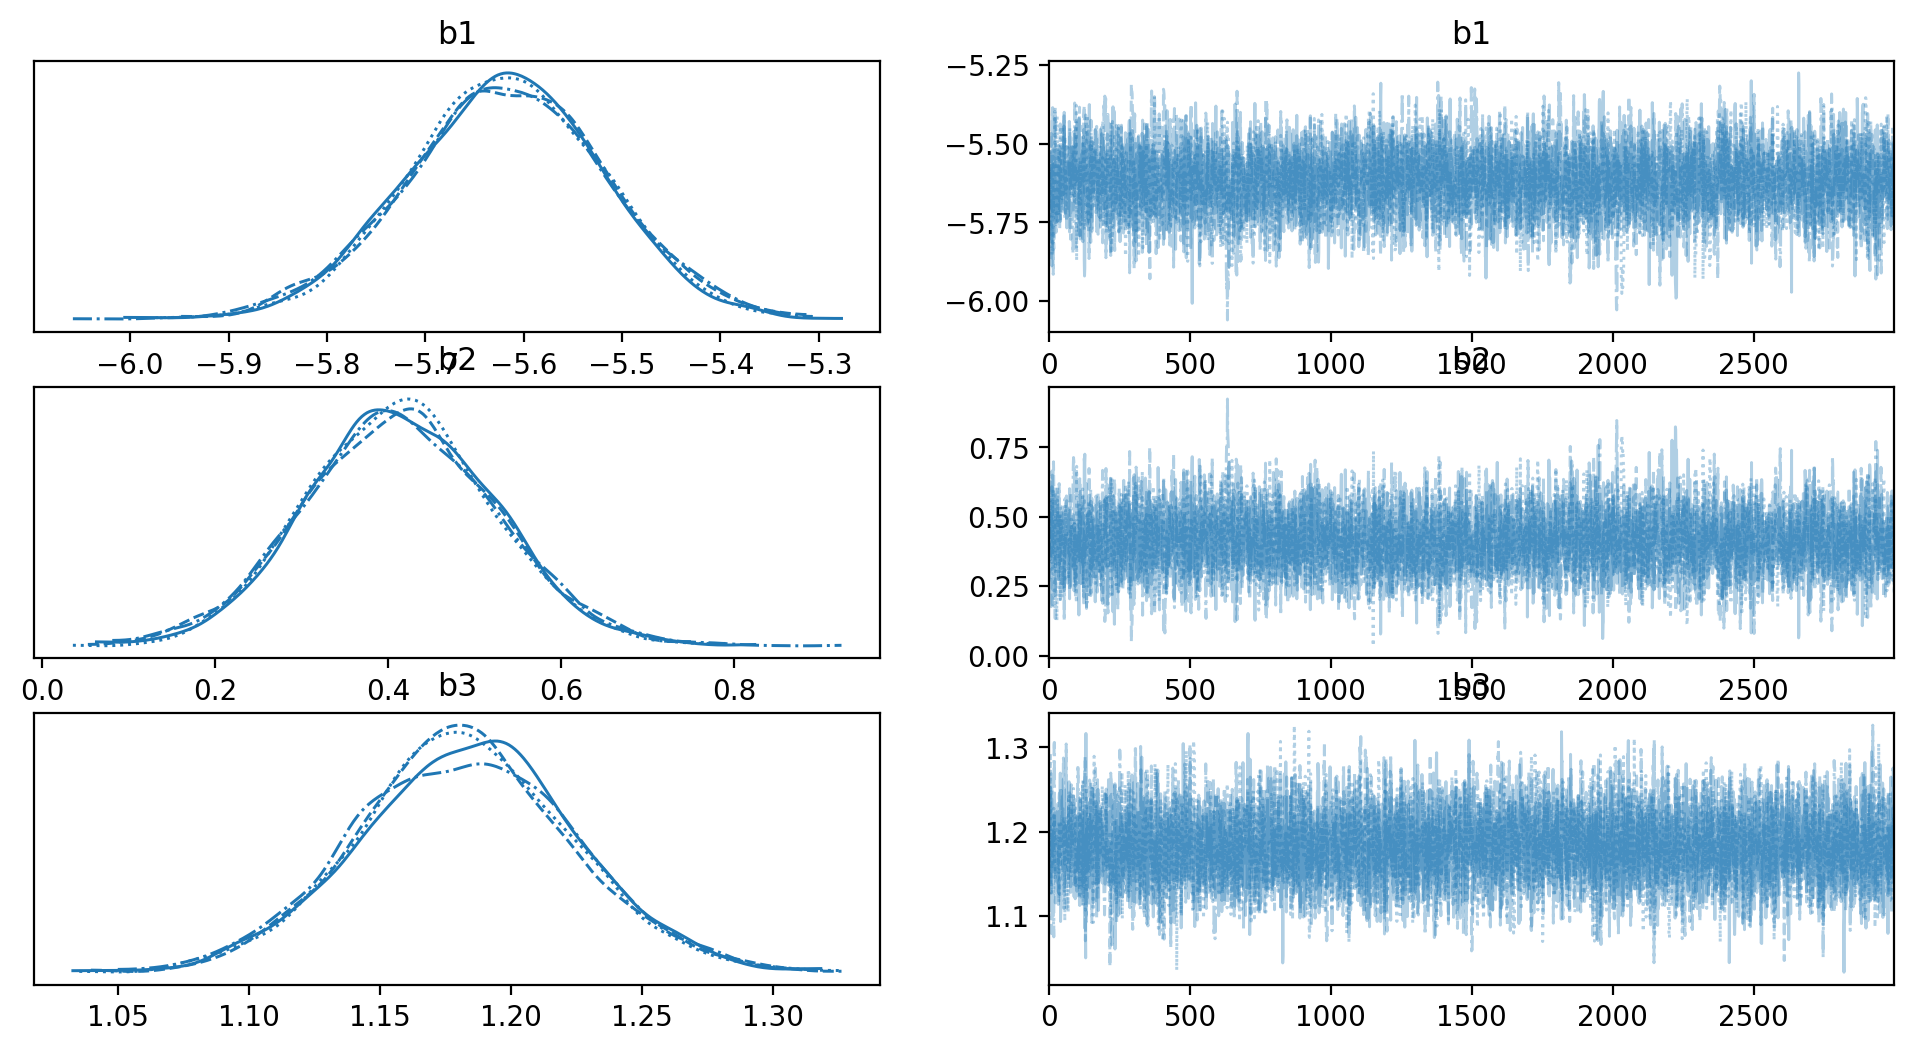

In [11]:
az.plot_trace(idata)

In [12]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b1,-5.619,0.101,-5.804,-5.420,0.002,0.001,3974.0,3706.0,1.0
b2,0.413,0.109,0.215,0.624,0.002,0.001,4045.0,4513.0,1.0
b3,1.183,0.041,1.107,1.262,0.001,0.000,6140.0,6127.0,1.0


array([<Axes: title={'center': 'b1'}>, <Axes: title={'center': 'b2'}>,
       <Axes: title={'center': 'b3'}>], dtype=object)

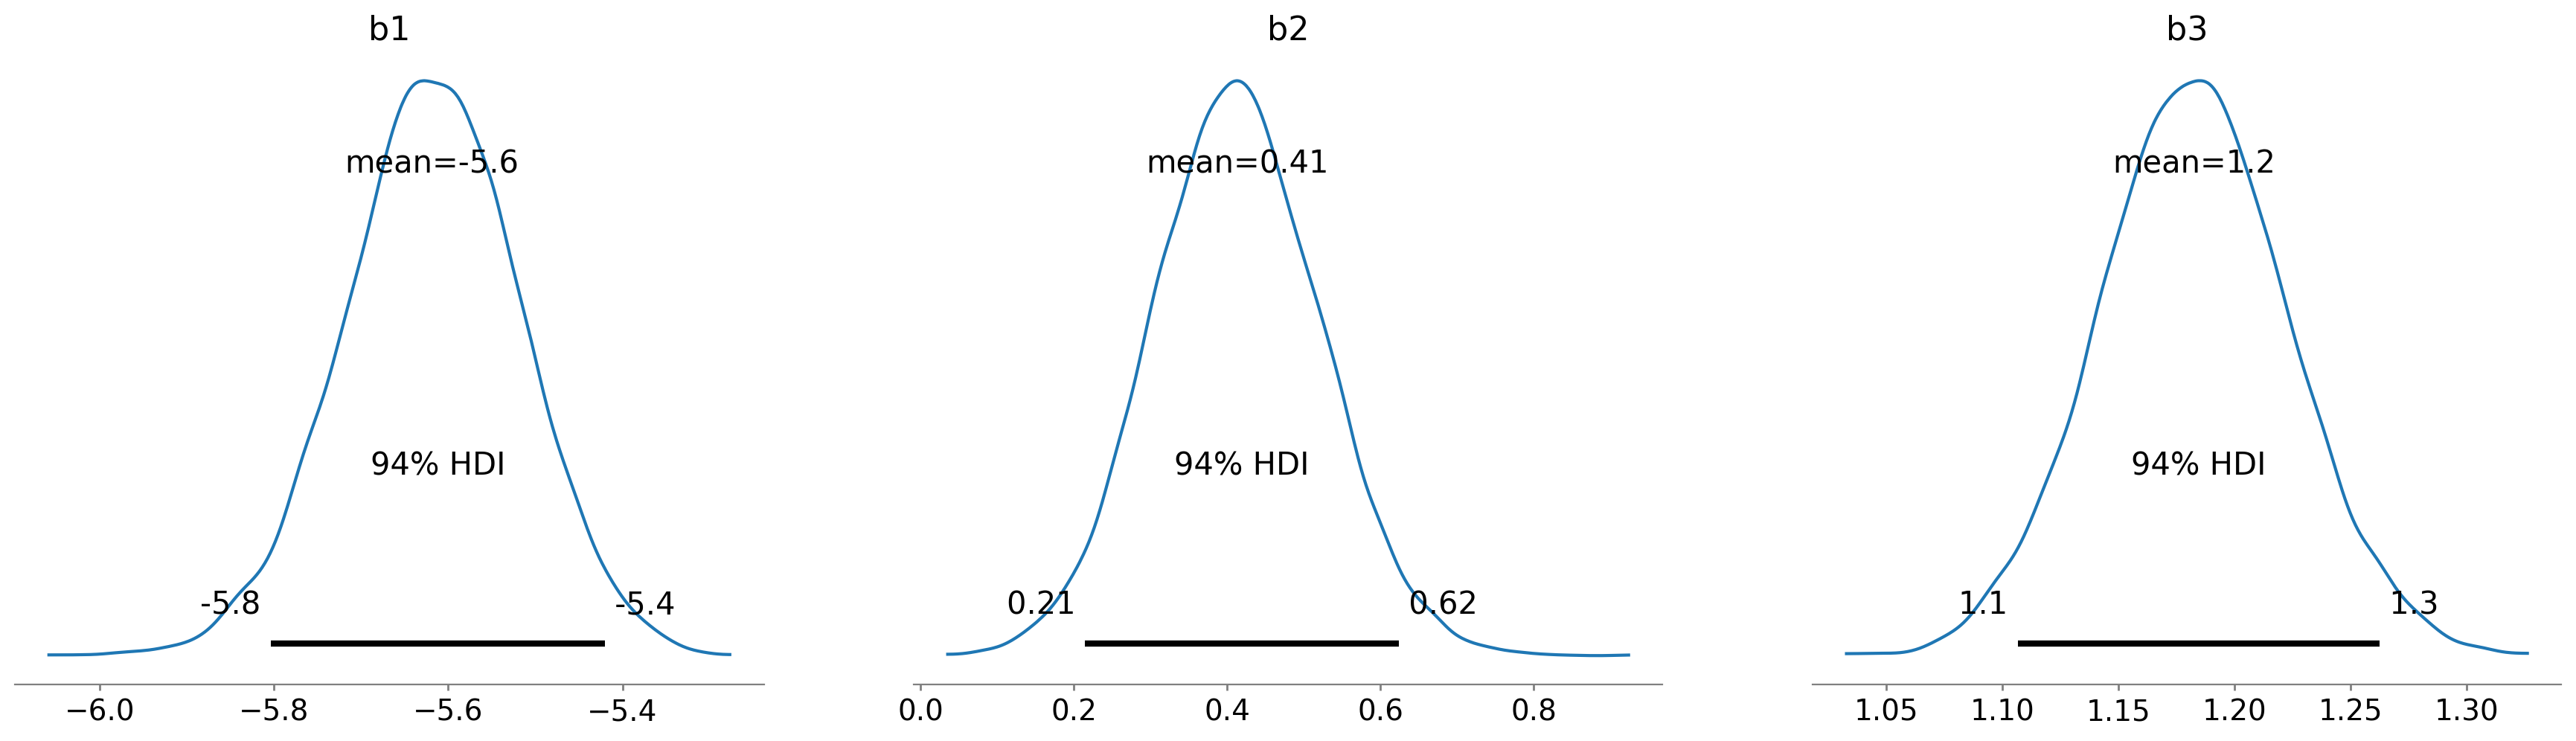

In [13]:
az.plot_posterior(idata)

係数としている `b2`, `b3` いずれも　0からずっと離れていて、両方とも係数としては意味がありそう、ということがわかる

array([<Axes: title={'center': 'b2'}>, <Axes: title={'center': 'b3'}>],
      dtype=object)

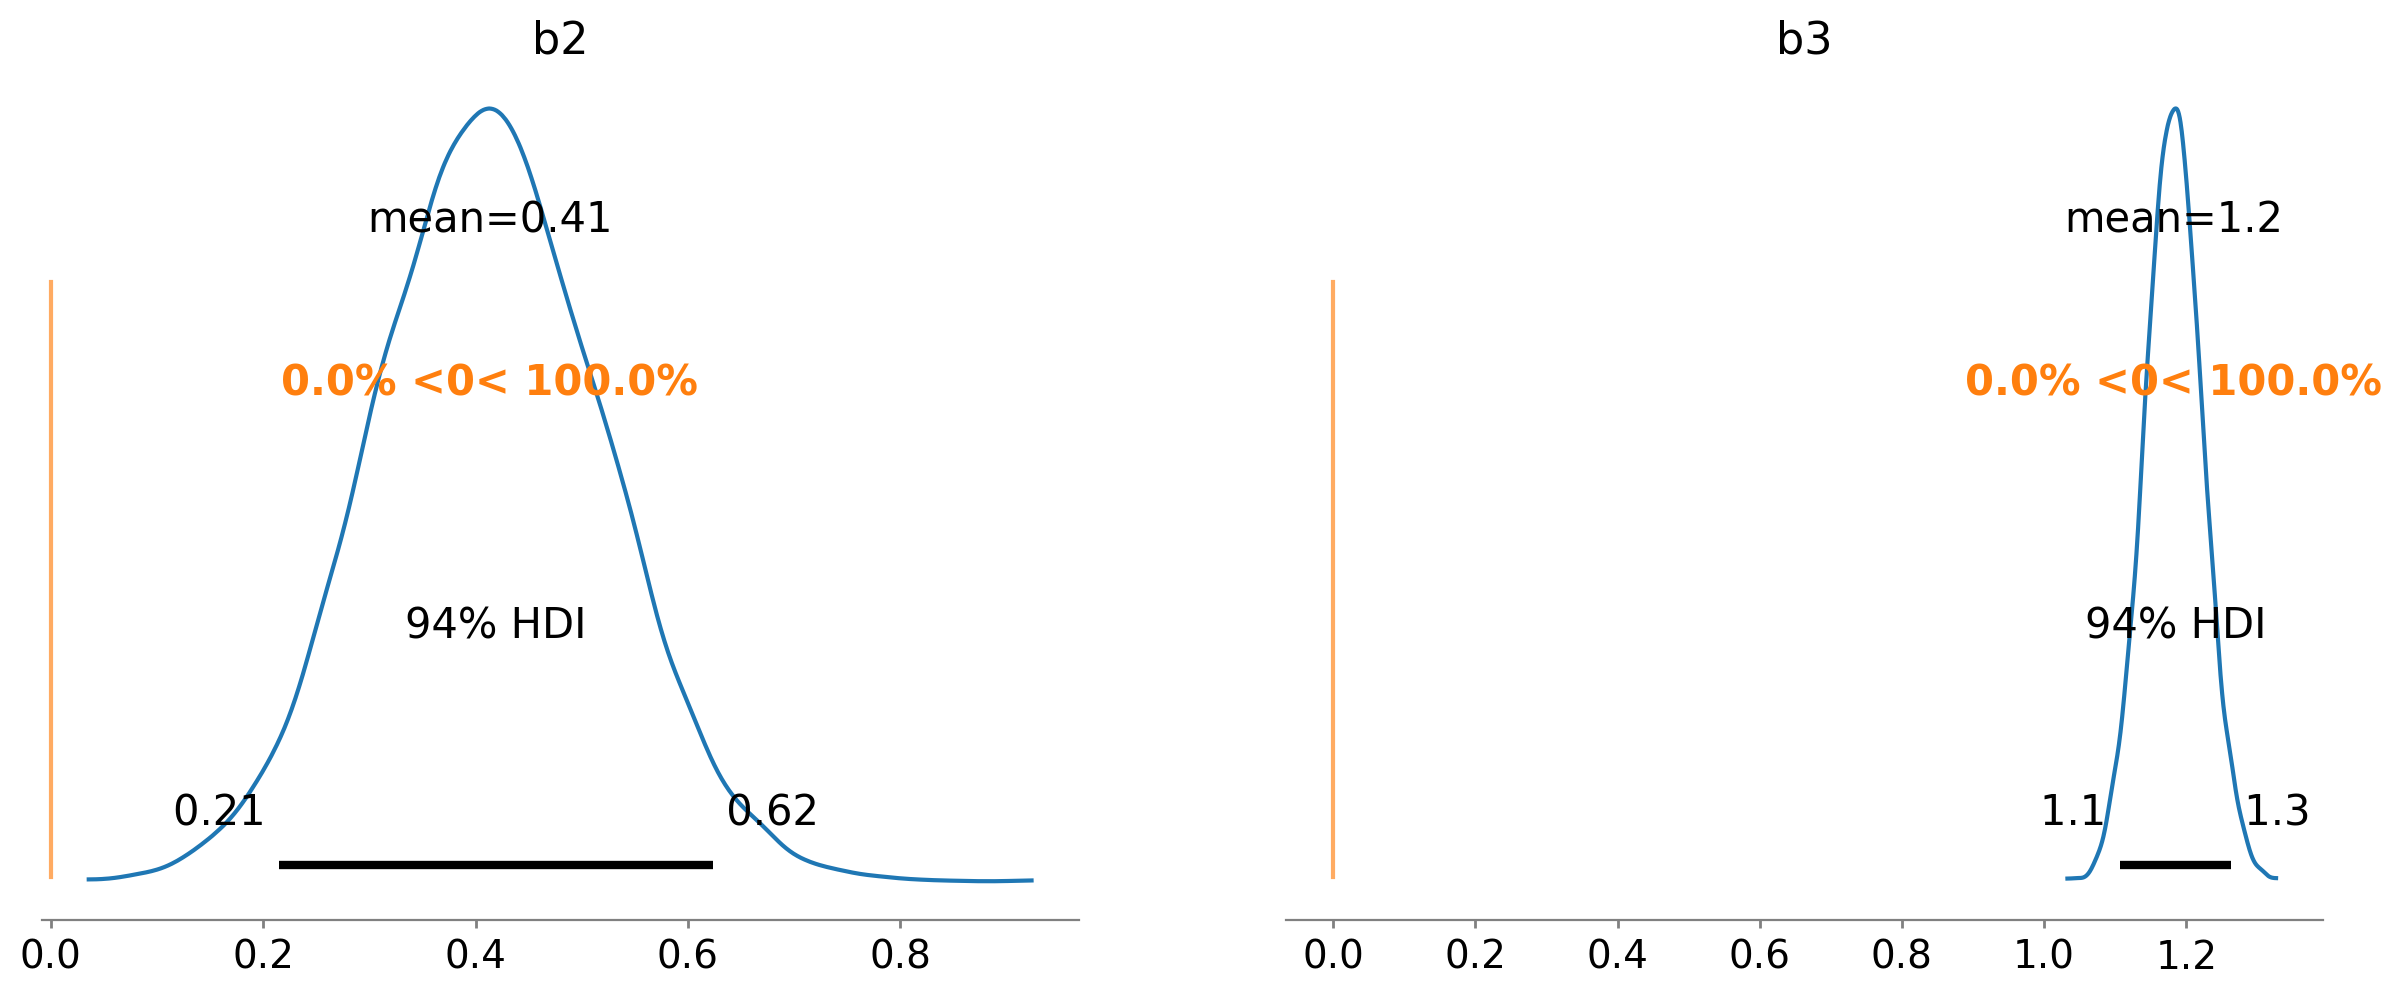

In [14]:
az.plot_posterior(idata, var_names = ['b2', 'b3'], ref_val = 0)

## 事後予測チェック（PPC：Post Predictive Check）
model がちゃんと真のパラメーターを説明できているかどうか

In [15]:
%%time
# 事後予測チェックは mcmc_samples を引数に入れて predictive を生成する

predictive = numpyro.infer.Predictive(model, mcmc_samples)
ppc_samples = predictive(jax.random.PRNGKey(42)
                         , smoke = smoke
                         , agecat_scaled = agecat_scaled
                         , population = population
                         , num_data = len(agecat_scaled))

idata_ppc = az.from_numpyro(mcmc, posterior_predictive = ppc_samples)

CPU times: user 643 ms, sys: 9.33 ms, total: 653 ms
Wall time: 492 ms


In [16]:
ppc_samples['obs'].shape

(12000, 10)

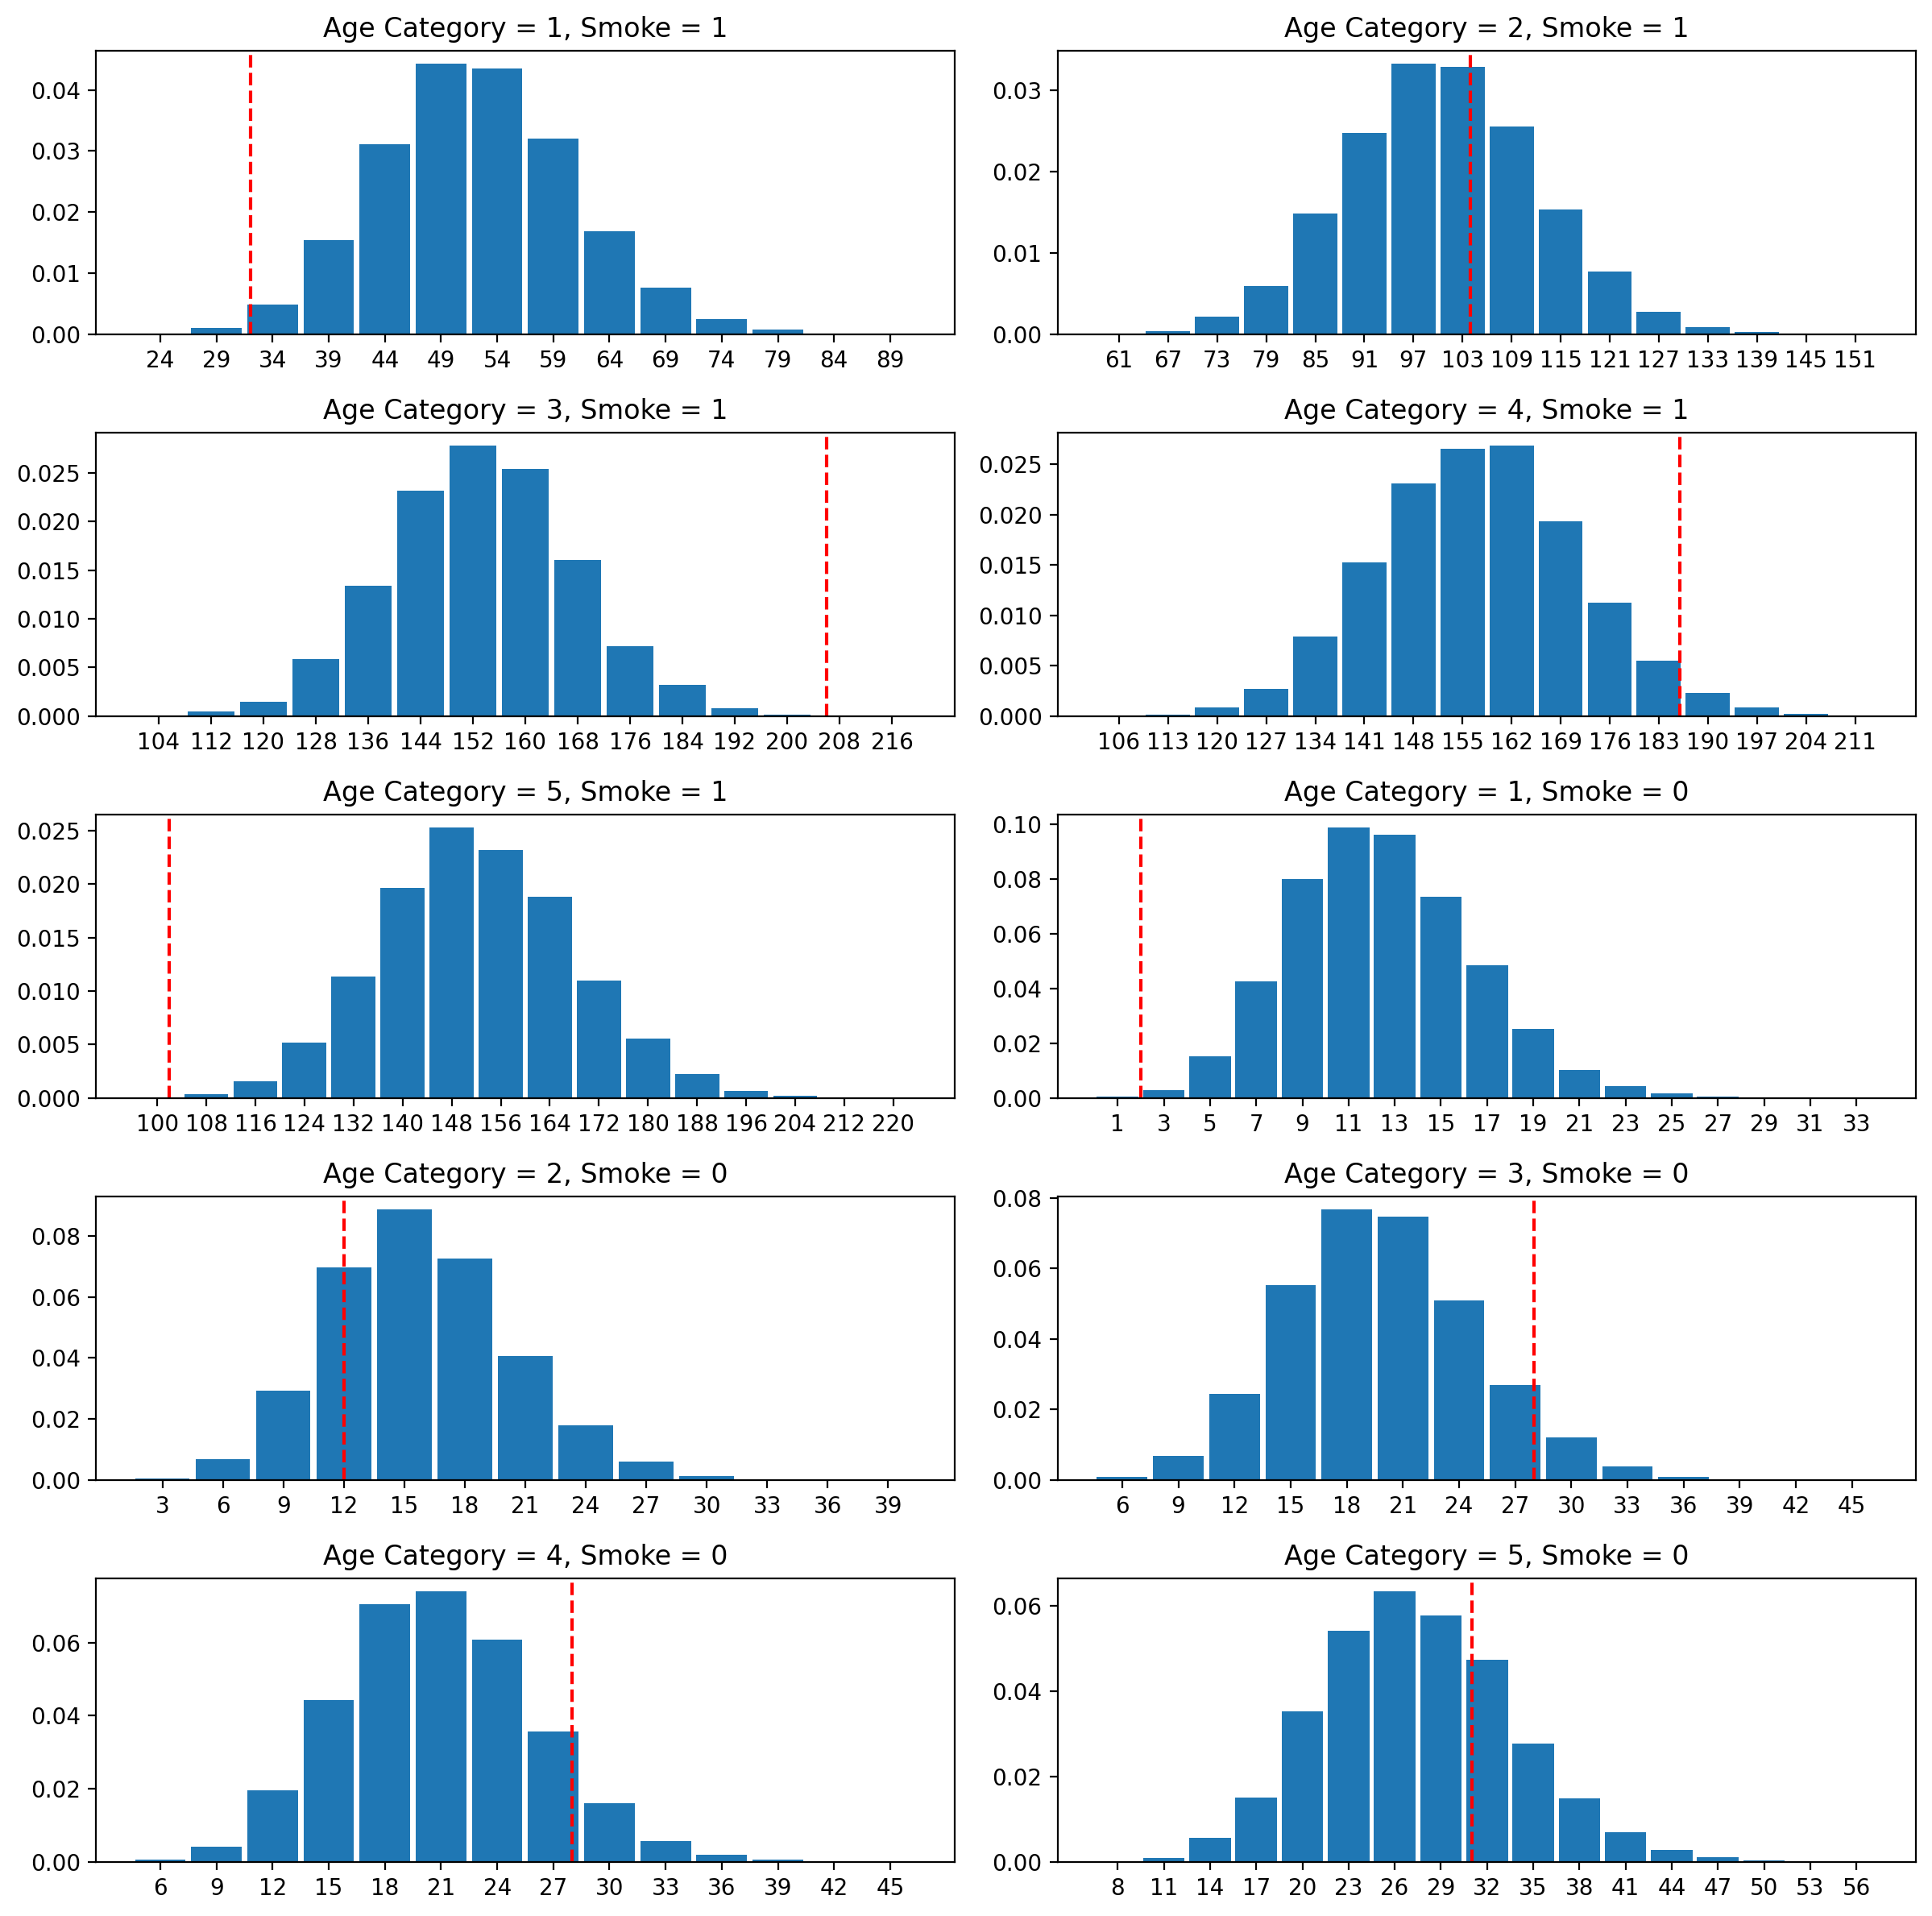

In [17]:
fig = plt.figure(figsize = (12, 12))

for k in range(10):
        
    ax = fig.add_subplot(5, 2, k+1)

    az.plot_dist(ppc_samples['obs'][:, k]) # ppc_samples の　obs なので mcmc で作ったサンプル(実際の観測データ10個に対して)
    ax.axvline(deaths[k], color = 'r', linestyle = 'dashed') # deaths　は実際の観測データ（8個）
    ax.set_title('Age Category = {}, Smoke = {}'.format(agecat[k], smoke[k]))

plt.tight_layout()

**解釈**：結果としては"すごく外れてそう"（わざと）
> + モデルがデータをうまく表現できていない?<br>
> + すごく変な値（外れ値）がありそう?

→ ひとつの項目で外れてたら変な値ありそうだけど、上記のとおり結構いろんな項目で値がずれているので、おそらく「モデルが悪いんじゃないか？」と思われる

In [18]:
# 一旦モデルダメそうだが推論結果を保存しておく
idata.to_netcdf('data/poisson_ng_idata_base.nc')

'data/poisson_ng_idata_base.nc'

## モデル直す

+ データの引数に **”交互作用項(Interaction Term)”** とか **”非線形項(Non-linear)”** を入れていく

■ 参考：
> [交互作用とは](https://bellcurve.jp/statistics/blog/14335.html)<br>
> [交互作用と交絡因子](https://statsbio.com/interaction-confounding/statistics/)

■ 疑問
+ 交互作用項はなんとなく、年齢が高い人が喫煙すると良くなさそうだから入れてみようってのはわかる。
+ 非線形項を入れようとするモチベーションとその推定結果から得られる洞察はどう解釈すればいいの？

In [19]:
agesq = agecat_scaled * agecat_scaled
smokeage = smoke * agecat_scaled

In [20]:
def model(smoke = None, agecat_scaled = None, agesq = None, smokeage = None, deaths = None, population = None, num_data = 0):

    b1 = numpyro.sample('b1_intercept', dist.Normal(0, 10))
    b2 = numpyro.sample('b2_smoke', dist.Normal(0, 10))
    b3 = numpyro.sample('b3_agecat', dist.Normal(0, 10))
    b4 = numpyro.sample('b4_agesq', dist.Normal(0, 10)) # 非線形項
    b5 = numpyro.sample('b5_smokeage', dist.Normal(0, 10)) # 交互作用項

    theta = b1 + b2 * smoke + b3 * agecat_scaled + b4 * agesq + b5 * smokeage

    mu = jax.numpy.exp(theta) * population

    with numpyro.plate('data', num_data):
        numpyro.sample('obs', dist.Poisson(rate = mu), obs = deaths)

In [21]:
nuts = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(nuts, num_warmup = 500, num_samples = 3000, num_chains = 4)

mcmc.run(jax.random.PRNGKey(42)
         , smoke = smoke
         , agecat_scaled = agecat_scaled
         , agesq = agesq
         , smokeage = smokeage
         , deaths = deaths
         , population = population
         , num_data = len(agecat_scaled))

mcmc_samples = mcmc.get_samples()

idata = az.from_numpyro(mcmc)

/var/folders/03/smvv0jp54c5cnt0xtqz_1gkc0000gn/T/ipykernel_12467/3907830829.py:2: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(nuts, num_warmup = 500, num_samples = 3000, num_chains = 4)
sample: 100%|█| 3500/3500 [00:01<00:00
sample: 100%|█| 3500/3500 [00:00<00:00
sample: 100%|█| 3500/3500 [00:00<00:00
sample: 100%|█| 3500/3500 [00:00<00:00


In [22]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

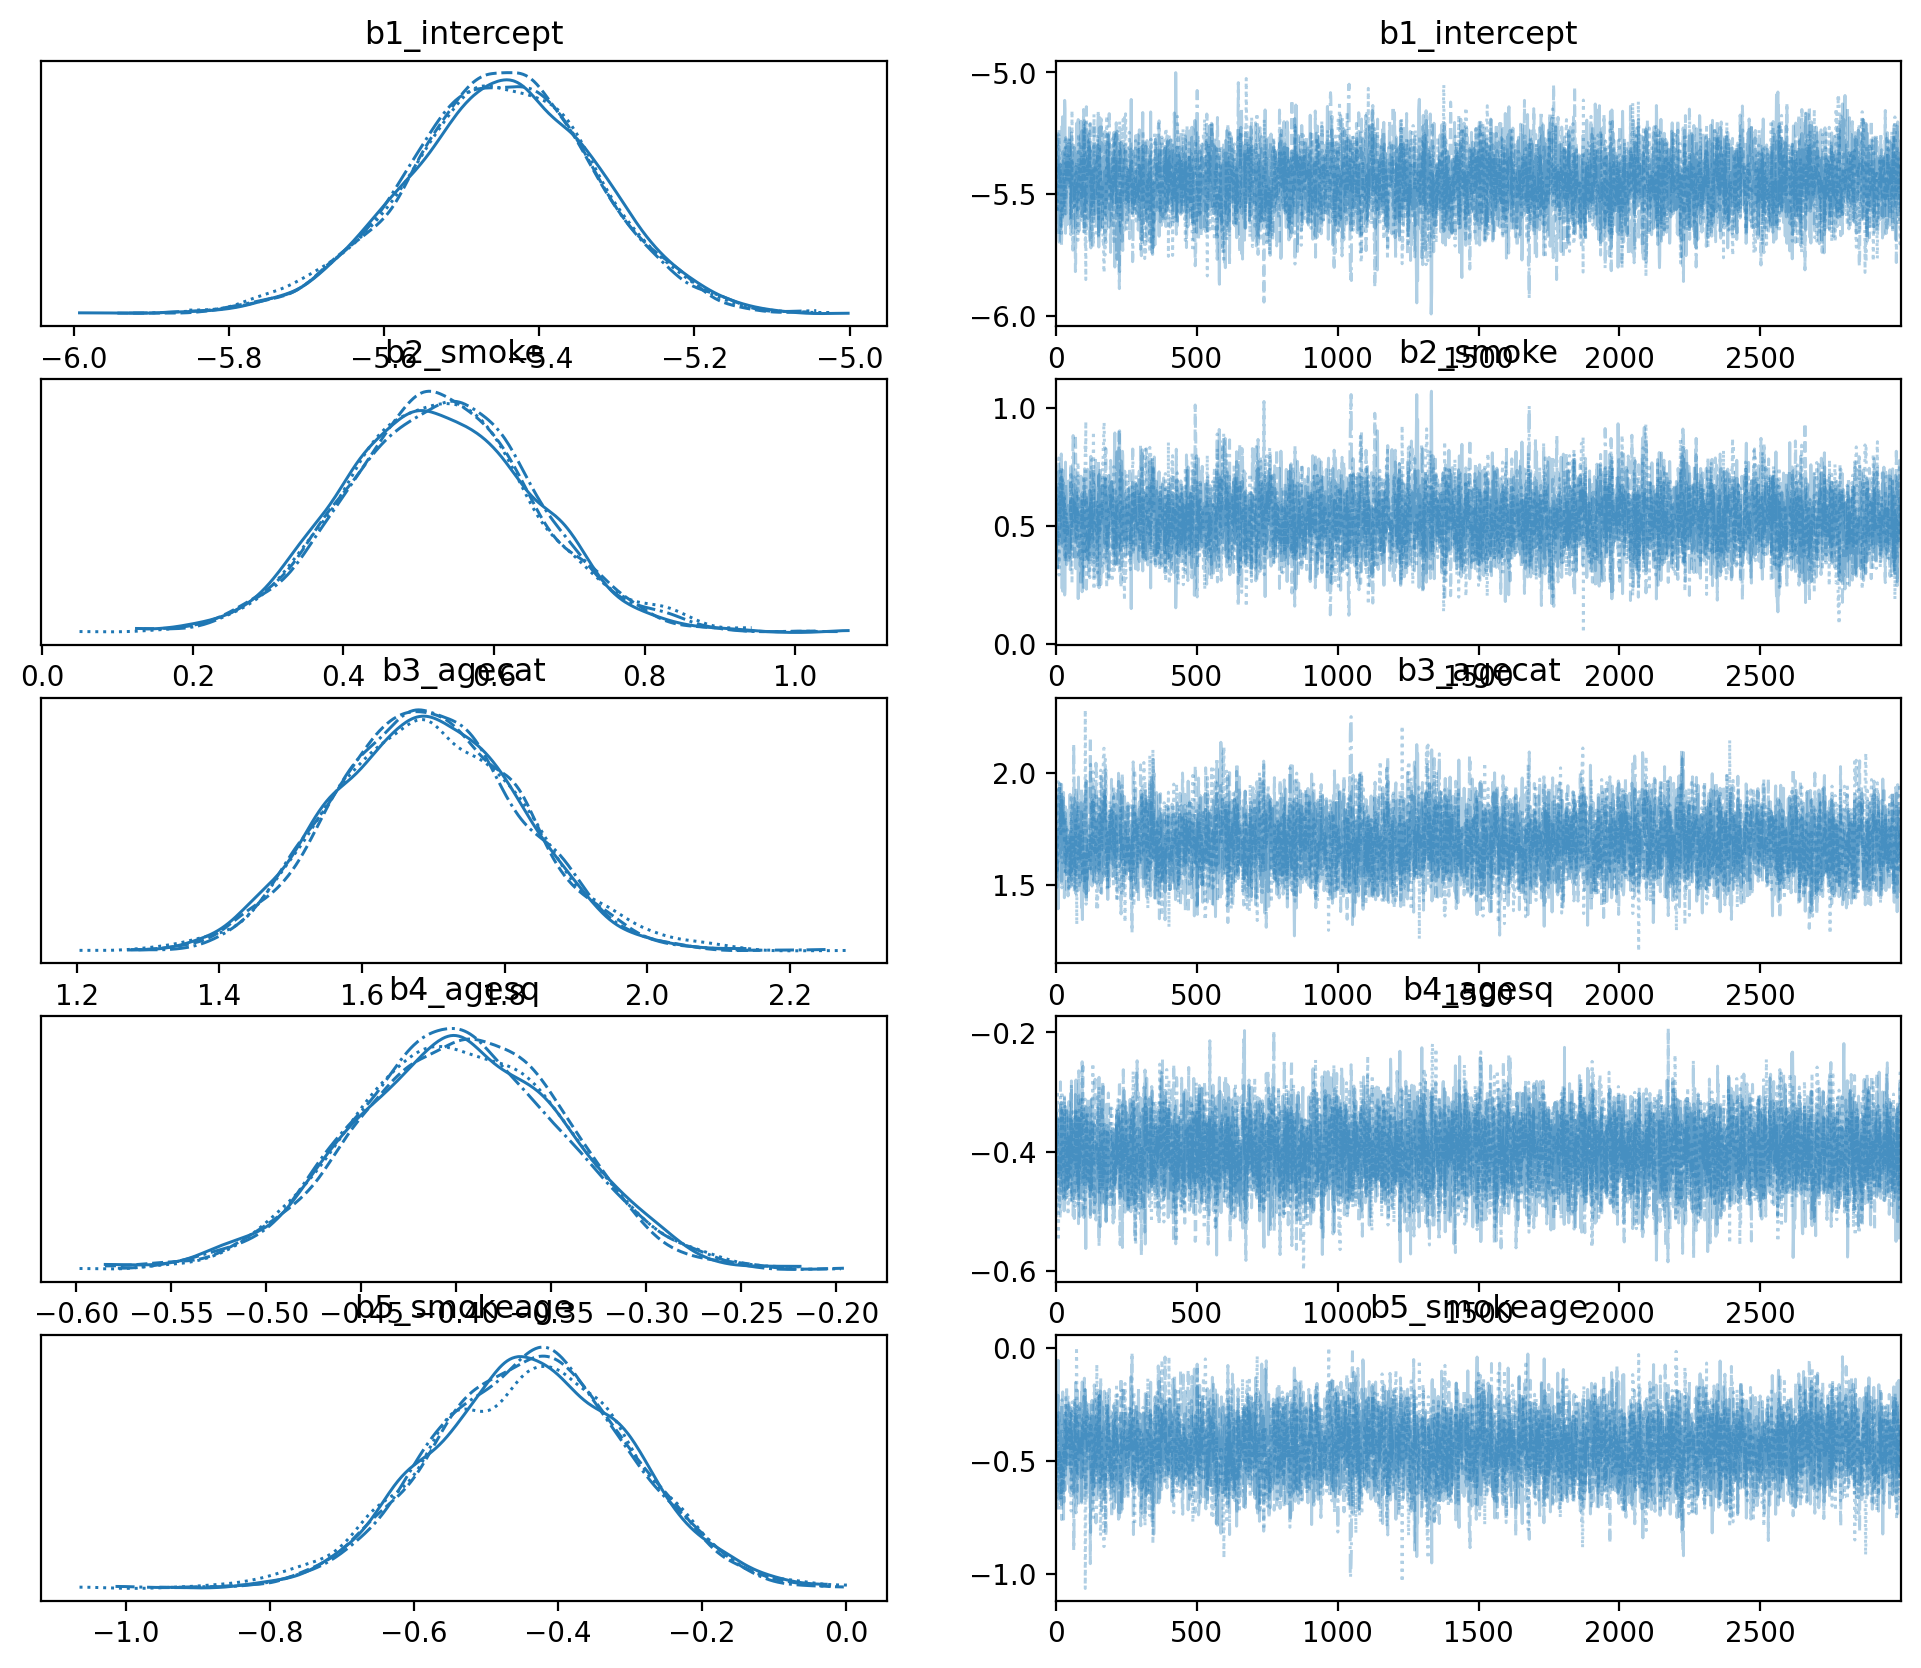

In [23]:
az.plot_trace(idata);

In [24]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b1_intercept,-5.451,0.123,-5.682,-5.218,0.002,0.001,4005.0,4813.0,1.0
b2_smoke,0.528,0.126,0.275,0.749,0.002,0.001,4030.0,5040.0,1.0
b3_agecat,1.692,0.131,1.453,1.937,0.002,0.001,4121.0,5688.0,1.0
b4_agesq,-0.400,0.055,-0.503,-0.297,0.001,0.000,6214.0,6678.0,1.0
b5_smokeage,-0.441,0.137,-0.689,-0.181,0.002,0.002,4145.0,5344.0,1.0


### パラメータの事後分布
参考点である0から大分離れているので意味がありそう

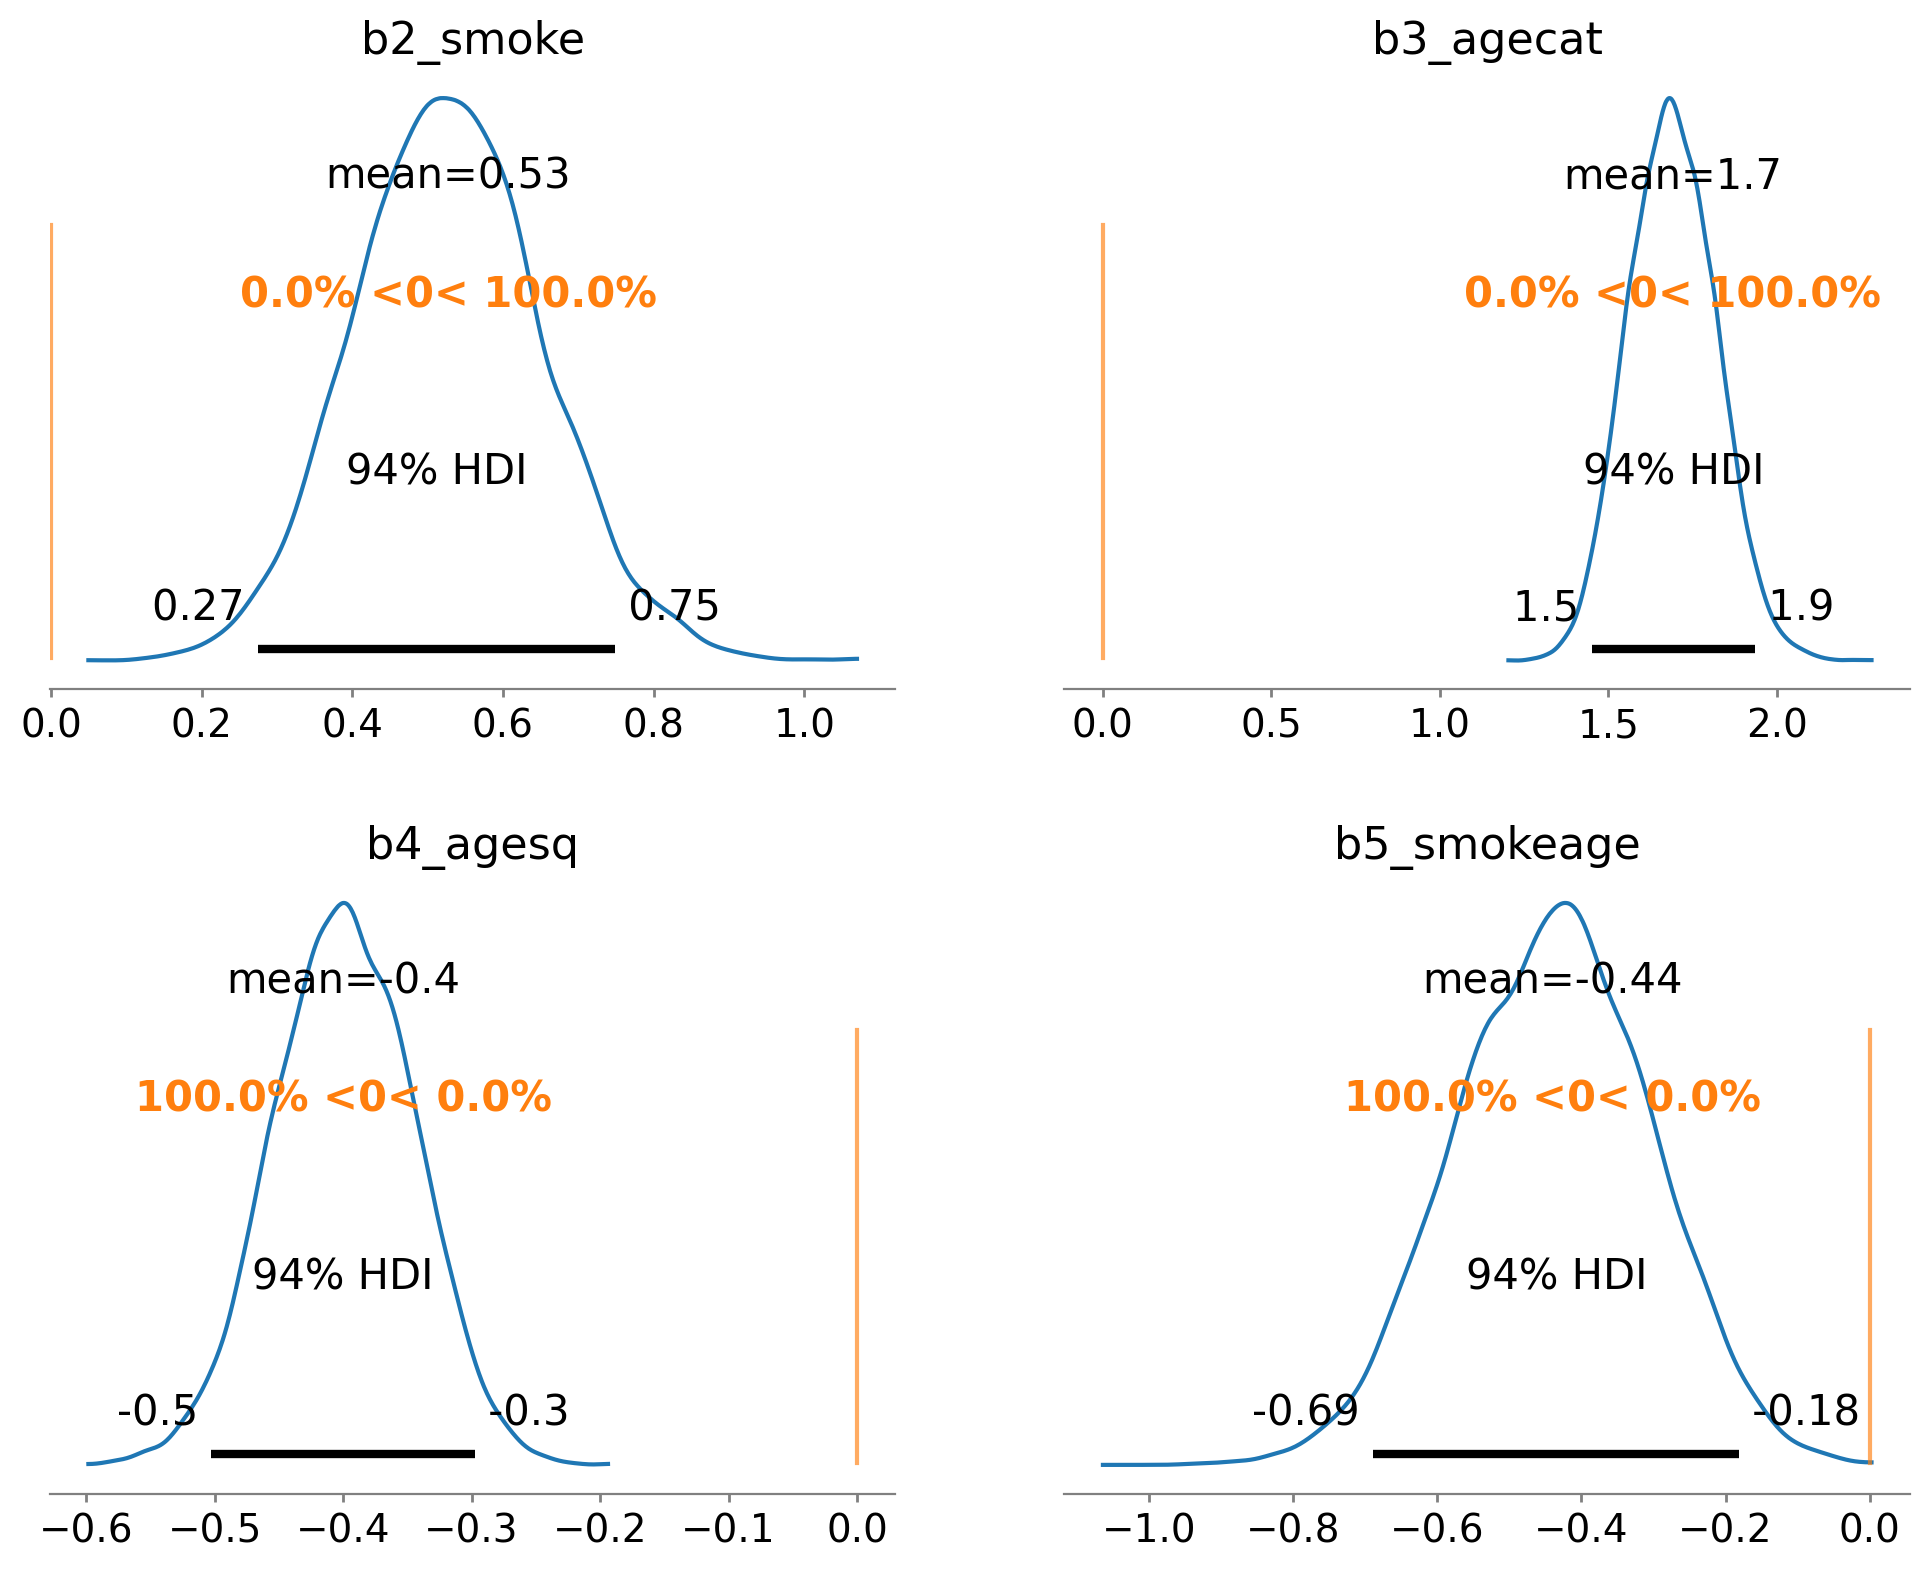

In [25]:
fig, axes = plt.subplots(2, 2, figsize = (12, 8))

az.plot_posterior(idata, var_names = ['b2_smoke', 'b3_agecat', 'b4_agesq', 'b5_smokeage'], ref_val = 0, ax = axes)

plt.subplots_adjust(top = 1.0, hspace = 0.3)

## 事後予測チェック（PPC：Post Predictive Check）
model がちゃんと真のパラメーターを説明できているかどうか

In [26]:
%%time
# 事後予測チェックは mcmc_samples を引数に入れて predictive を生成する

predictive = numpyro.infer.Predictive(model, mcmc_samples)
ppc_samples = predictive(jax.random.PRNGKey(42)
                         , smoke = smoke
                         , agecat_scaled = agecat_scaled
                         , agesq = agesq
                         , smokeage = smokeage
                         , population = population
                         , num_data = len(agecat_scaled))

idata_ppc = az.from_numpyro(mcmc, posterior_predictive = ppc_samples)

CPU times: user 431 ms, sys: 9.29 ms, total: 440 ms
Wall time: 431 ms


In [27]:
ppc_samples['obs'].shape

(12000, 10)

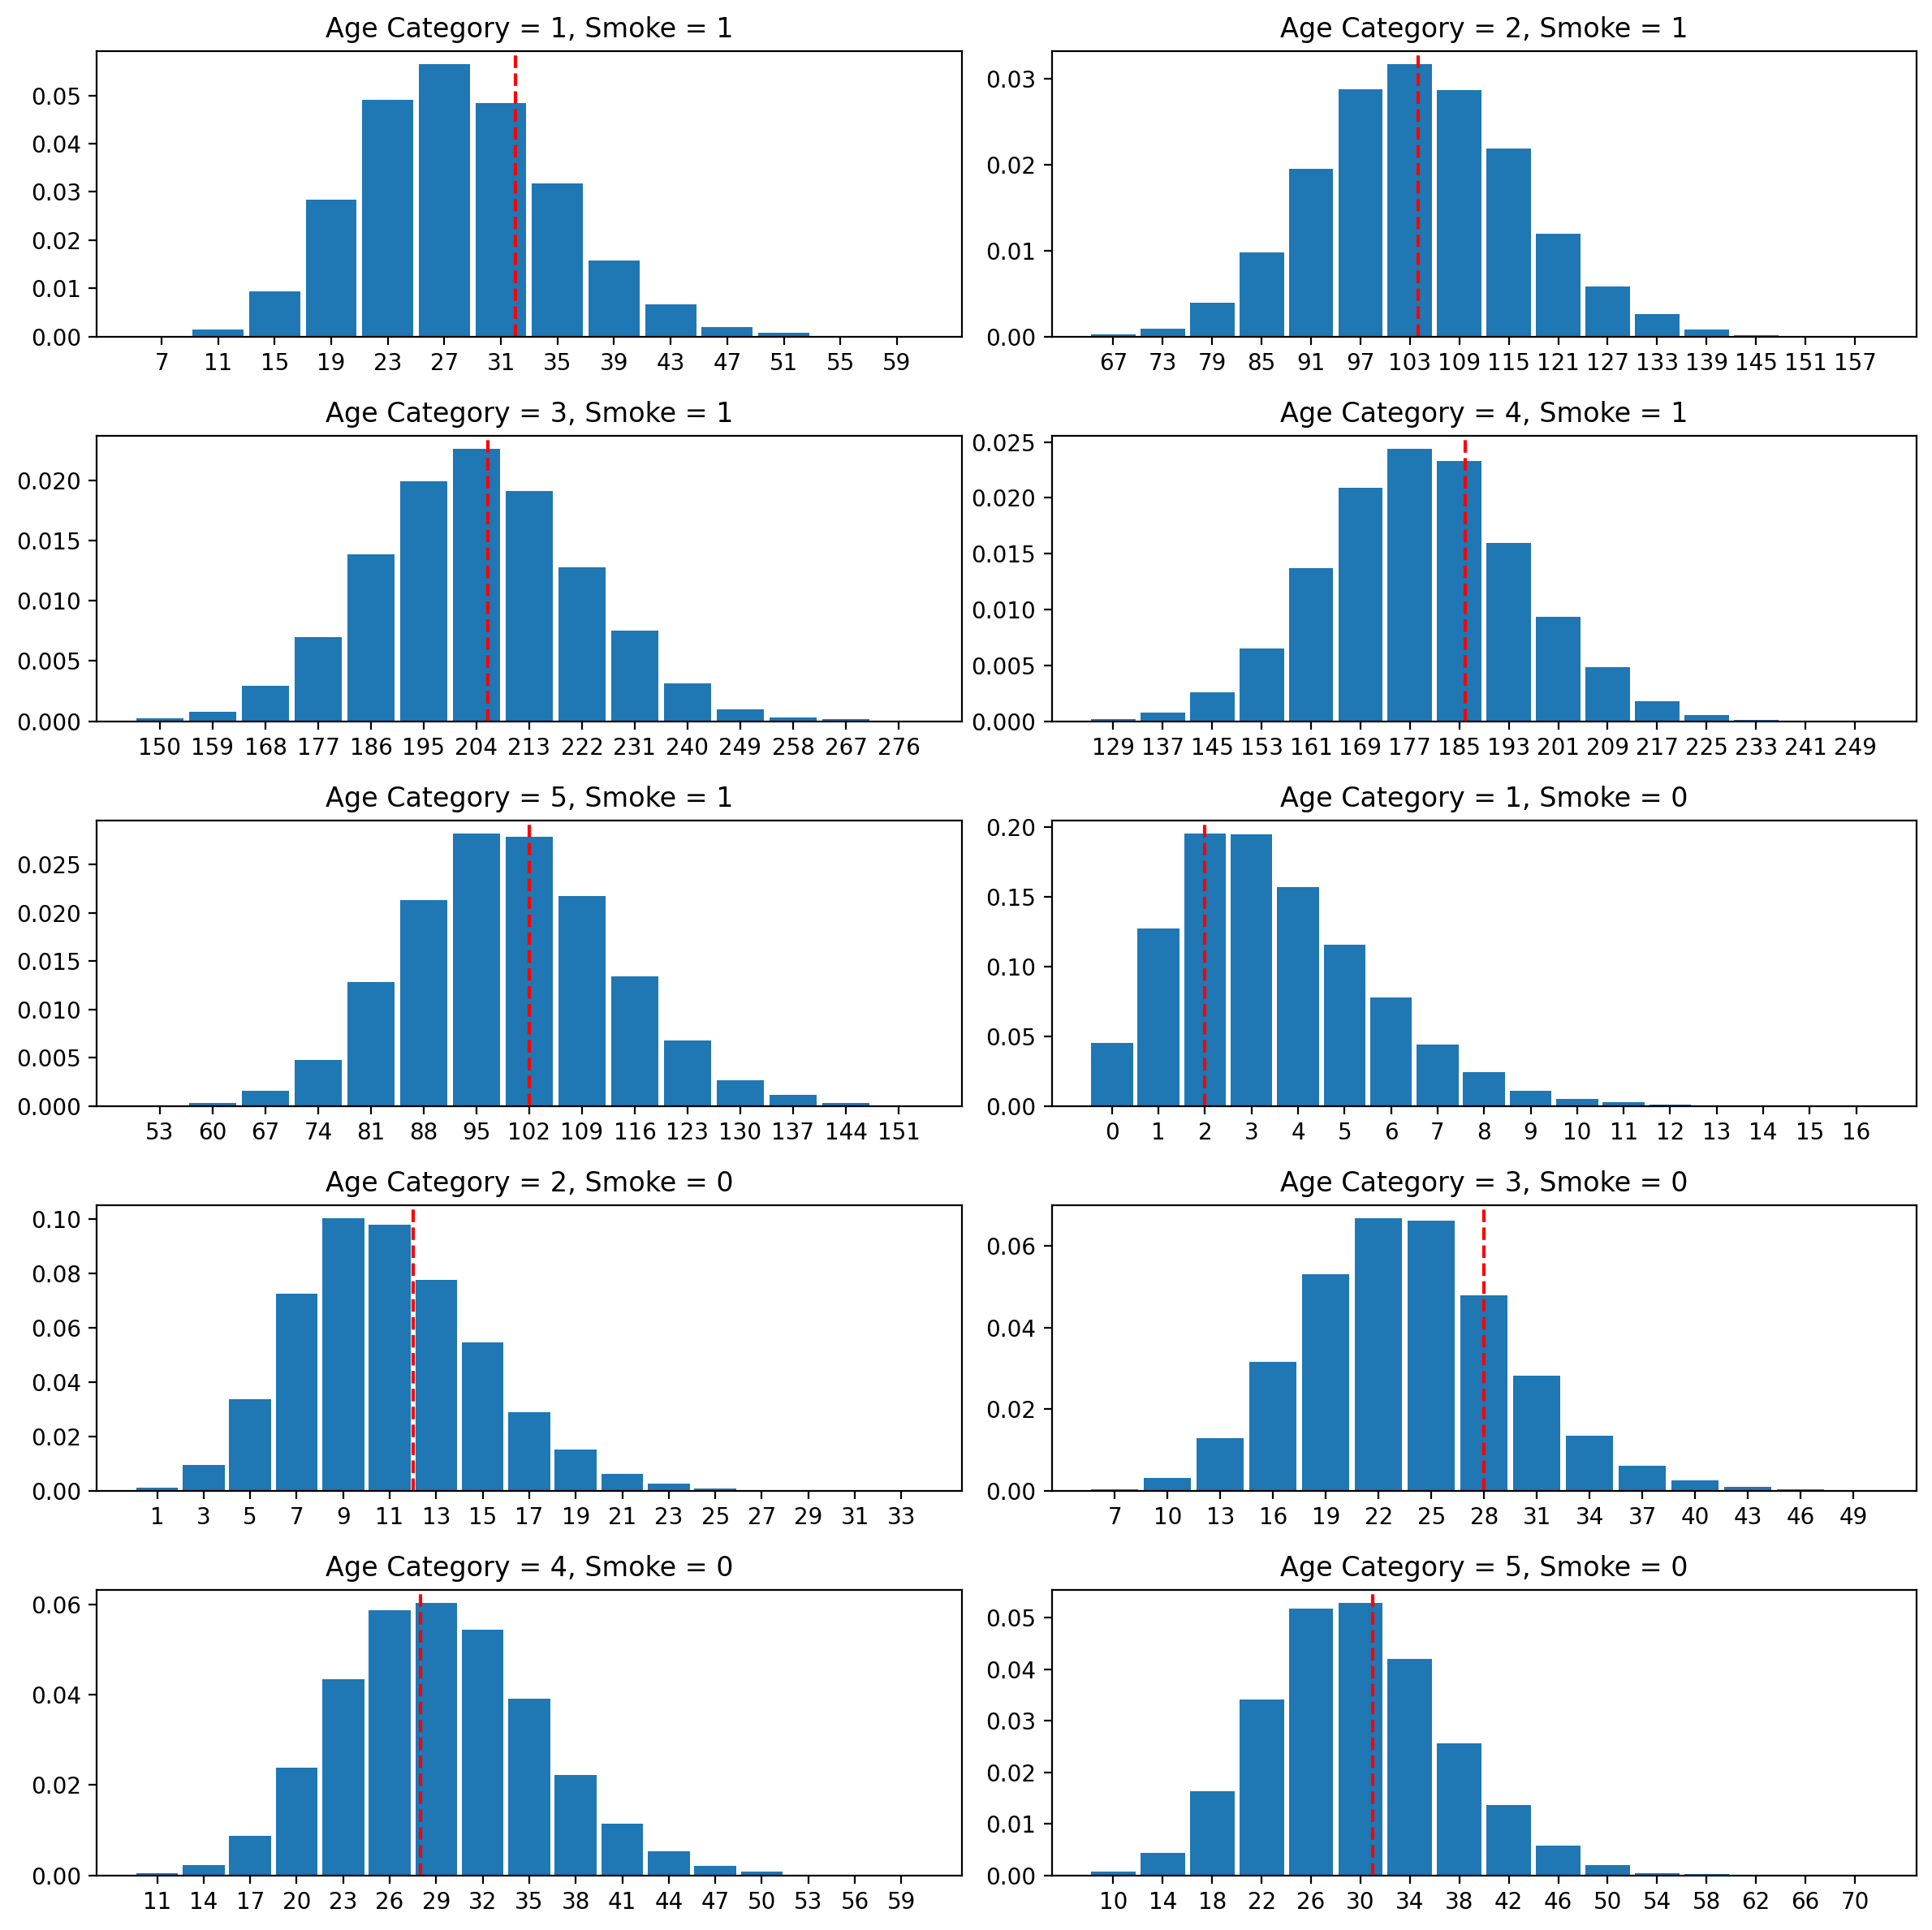

In [28]:
fig = plt.figure(figsize = (12, 12))

for k in range(10):
        
    ax = fig.add_subplot(5, 2, k+1)

    az.plot_dist(ppc_samples['obs'][:, k]) # ppc_samples の　obs なので mcmc で作ったサンプル(実際の観測データ10個に対して)
    ax.axvline(deaths[k], color = 'r', linestyle = 'dashed') # deaths　は実際の観測データ（8個）
    ax.set_title('Age Category = {}, Smoke = {}'.format(agecat[k], smoke[k]))

plt.tight_layout()

**解釈**：へんなところなさそう

## モデル比較（WAIC & LOO）

In [29]:
# 上で保存しといたデータの読み込み
idata_base = az.from_netcdf('data/poisson_ng_idata_base.nc')

In [30]:
dict_idata = {'Linear Terms Only': idata_base, 'Interaction and Non-linear Term Added': idata}

In [31]:
dict_idata = {'A': idata_base, 'B': idata}

### WAIC（Watanabe-Akaike Information Criterion）

In [32]:
df_waic = az.compare(dict_idata, ic = 'waic', scale = 'deviance')

/Users/kazutak/Git/AB_test/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/kazutak/Git/AB_test/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/kazutak/Git/AB_test/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'deviance' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


In [33]:
df_waic['scale']

B    deviance
A    deviance
Name: scale, dtype: object

/Users/kazutak/Git/AB_test/.venv/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


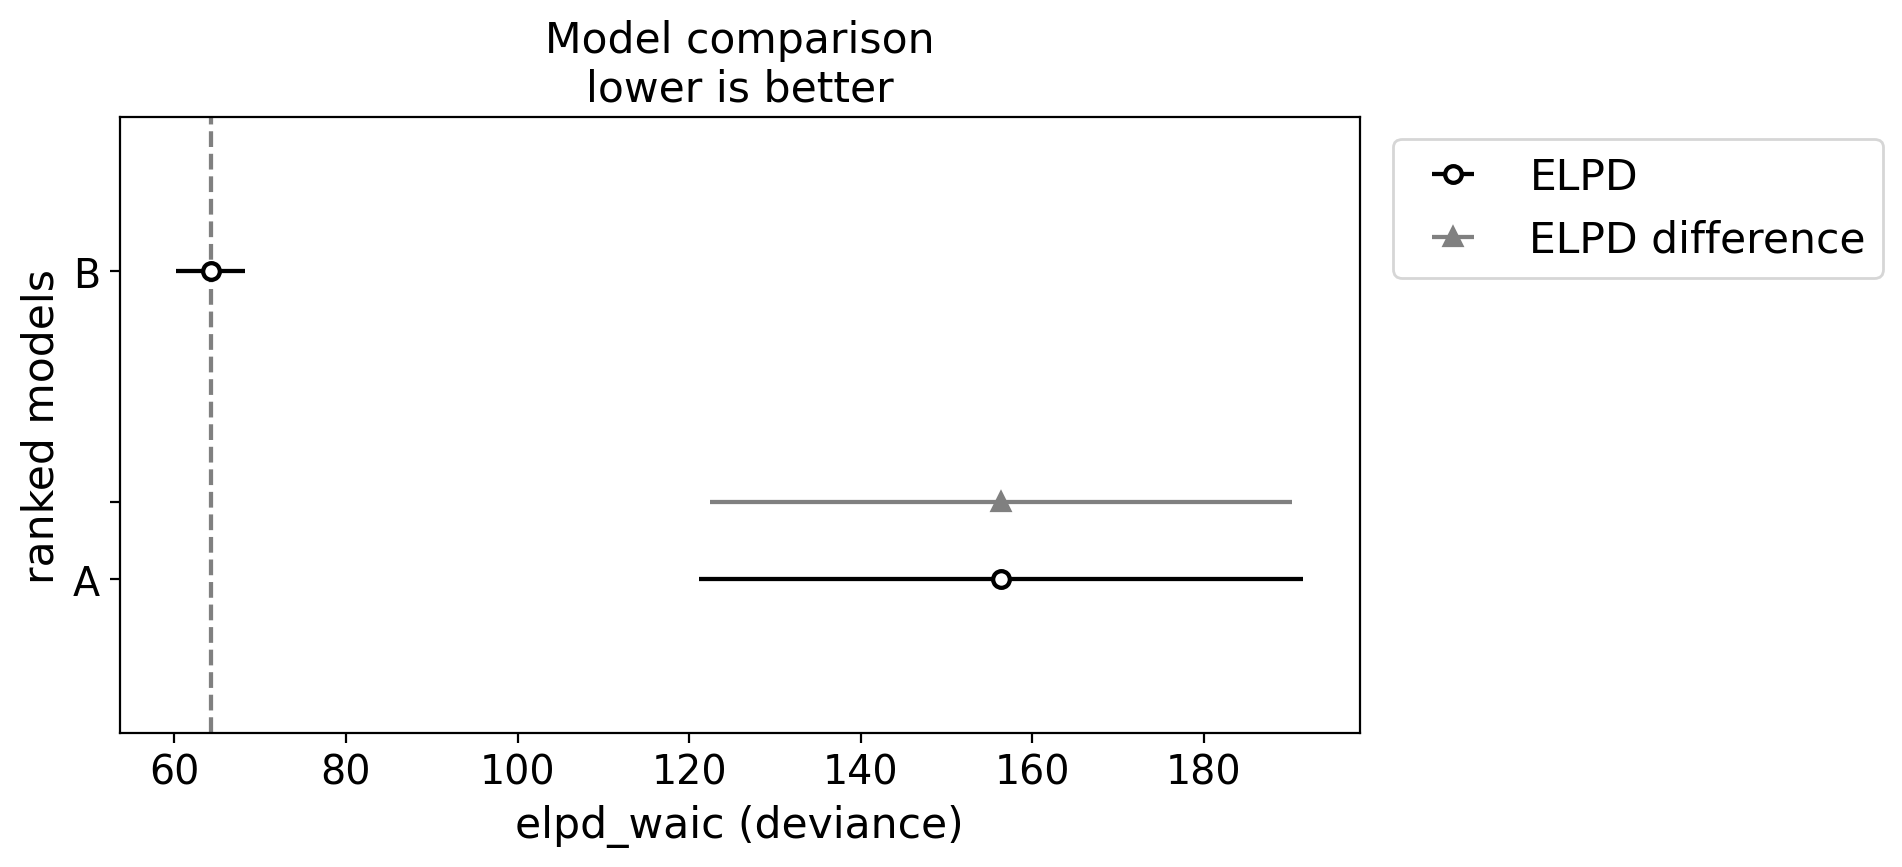

In [34]:
az.plot_compare(df_waic, figsize = (8, 4));

### LOO（Leave-One-Out Cross-Validation）
1. データセットから一つの観測値を除外します。
2. 除外されたデータを除いてモデルをフィットします。
3. 除外したデータ点に対するモデルの予測性能を評価します。これは通常、対数尤度などの統計量を用いて行われます。
4. このプロセスをデータセットの各観測値に対して繰り返し、予測性能の合計または平均を計算します。

> LOOの利点は、各観測値がモデルの評価にどのように影響するかを明らかにすることができる点です。<br>
> これにより、特定のデータポイントがモデルのパフォーマンスに異常な影響を与えていないかを確認することができます。<br>
> ベイズ統計モデルでは、LOOを実施するためにPSIS-LOO（Pareto Smoothed Importance Sampling Leave-One-Out）という手法がよく用いられます。<br>
> この手法は、計算コストを大幅に削減しつつ、LOOの精度を保つことができます。<br>
> WAICとLOOはともにベイズモデルの比較と選択に用いられる手法であり、どちらもモデルの予測性能を測定することを目的としています。<br>
> しかし、それぞれ異なるアプローチを取るため、特定の状況やデータセットによっては一方が他方よりも優れている場合があります。<br>
> モデル選択の文脈では、これらの基準を相補的に使用することが一般的です。

In [35]:
df_loo = az.compare(dict_idata, ic = 'loo', scale = 'deviance')
df_loo

/Users/kazutak/Git/AB_test/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/kazutak/Git/AB_test/.venv/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/kazutak/Git/AB_test/.venv/lib/python3.9

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
B,0,65.057783,2.399911,0.000000,1.000000e+00,4.115543,0.000000,True,deviance
A,1,159.638475,24.398839,94.580692,4.796163e-13,36.079713,34.611644,True,deviance


### ■ 質問
一般化線形モデル（ポワソン回帰）を作る際に、非線形項を導入はどのような場合に検討すべきですか？<br>
例えば、交互作用項を入れようとするのは、喫煙と年齢といったような相互作用がある場合ですが、年齢の二乗といった値をパラメーターとして導入するのはどういう仮説・背景に基づくのかわかりません。

### ■ 回答

一般化線形モデル（GLM）において非線形項（例えば、二乗項や交互作用項）を導入するかどうかは、データの特性と分析の目的に基づいて判断されます。<br>
特にポワソン回帰のようなカウントデータに対するモデルでは、非線形の関係性をモデルに組み込むことで、より現実に近い予測や解釈が可能になることがあります。以下にいくつかの一般的なシナリオを示します：

***曲線的な関係のモデリング***：
+ 例えば、年齢の二乗項を導入することは、年齢と応答変数との関係が単純な直線ではなく曲線的（例：若者と高齢者で異なる効果がある場合）であることを示唆しています。
+ これは、特定の年齢範囲で効果が増大または減少することをモデルに組み込む際に有効です。

***飽和効果や閾値のモデリング***：
+ ある変数の効果が一定レベルに達した後に減少する（または増加する）という現象をモデル化する際に、二乗項やその他の非線形項が役立ちます。
+ 例えば、広告支出と売上の関係で、あるポイントを超えると売上の増加が鈍化する場合などです。

***生物学的、経済学的、心理学的理論に基づく場合***：
+ 特定の理論や以前の研究が、変数間の非線形関係を示唆している場合、それをモデルに組み込むことが適切です。
+ 例えば、心理学においては、ストレスとパフォーマンスの関係がU字型であるとされることがあります。

***データ探索とモデル適合の改善***：
+ データを詳細に分析し、変数間の関係が非線形である可能性があると判断した場合、非線形項の導入を検討することが有効です。
+ また、モデルの適合度を改善するために非線形項を試すことも一般的です。

非線形項の導入は、モデルの複雑さを増加させるため、必ずしも常に適切なわけではありません。<br>
そのため、非線形項を導入する際は、理論的な根拠、データの特性、モデルの解釈可能性などを総合的に考慮することが重要です。<br>
また、非線形項を導入した場合のモデルのパフォーマンス（例えば、交差検証による評価）をチェックし、線形モデルと比較して改善が見られるかを評価することも重要です。